<center><img src='../../img/ai4eo_logos.jpg' alt='Logos AI4EO MOOC' width='80%'></img></center>

<hr>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1183058"><< Back to FutureLearn</a><br>

# ML4Floods - Run inference of a flood extent segmentation model using Sentinel-2 data

<i>by Sam Budd and Gonzalo Mateo-Garcia, Frontier Development Lab</i>

<hr>

## Watch the video tutorial

In [1]:
from IPython.display import HTML
HTML('<div align="center"><iframe src="https://player.vimeo.com/video/510225048" width="640" height="360" frameborder="0" allow="autoplay; fullscreen; picture-in-picture" allowfullscreen align="middle"></iframe></div>')     

<br>

<hr>

## Introduction

This notebook guides you step-by-step through the inference process of a flood extent segmentation model using Sentinel-2 data. You will load a trained model from the [ml4floods](https://github.com/spaceml-org/ml4floods) project. With that model, you will then make predictions on new Sentinel-2 images.

## Machine Learning model

The workflow makes use of a pre-trained model, which is available as part of the [ml4floods](https://github.com/spaceml-org/ml4floods) project. The model used has the experiment number `"WFV1_unet"` and is a trained neural network.  Get more information about the training process and the model itself in the [training notebook](./6F_ml4floods_training.ipynb).

## Data

The workflow makes use of the following datasets which are used for the inference process:
* `Sentinel-2 image` to be classified
* `Ground-truth` image classified in six classes
* `Permanent water mask created by the Joint Research Centre (JRC)` for comparison purpose

All data are available as part of the [ml4floods](https://github.com/spaceml-org/ml4floods) project and will, if not available, be downloaded to your workspace.

## Further resources

* [ML4Floods Github repository](https://github.com/spaceml-org/ml4floods)
* [ML4Floods - An ecosystem of data, models and code piplines to tackle flooding with Machine Learning](http://trillium.tech/ml4floods/content/intro/introduction.html)
* [Towards global flood mapping  onboard low cost satellites with machine learning](https://www.nature.com/articles/s41598-021-86650-z)


<hr>

## Notebook outline

* [1 - Load configuration information](#load_config_6f2)
* [2 - Load a pre-trained model](#load_model_6f2)
* [3 - Load data for inference](#load_inference_data_6f2)
* [4 - Perform inference using the inference function](#inference_function_6f2)
* [5 - Repeat the inference process on another Sentinel-2 file](#inference_repeat_6f2)


<hr>

#### Import libraries

In [2]:
import sys, os
from pathlib import Path

import fsspec
from pytorch_lightning import seed_everything
import pkg_resources

from ml4floods.models.config_setup import get_default_config
from ml4floods.models.model_setup import get_model,get_model_inference_function,get_channel_configuration_bands

import warnings
warnings.filterwarnings("ignore")

#### Load helper functions

In [3]:
%run ./6F_ml4floods_functions.ipynb

<hr>

## <a id='load_config_6f2'></a>1. Load configuration information

The first step is to load a configuration file, which is available as part of the [ml4floods](https://github.com/spaceml-org/ml4floods) library. The experiment you are interested to load is `WFV1_unet`.

The function `get_default_config()` from the [ml4floods](https://github.com/spaceml-org/ml4floods) libary loads the JSON file. 

In [4]:
experiment_name = "WFV1_unet"

config_fp = f"worldfloods_v1_sample/checkpoints/{experiment_name}/config.json"
config = get_default_config(config_fp)

Loaded Config for experiment:  WFV1_unet
{   'data_params': {   'batch_size': 32,
                       'bucket_id': 'ml4floods',
                       'channel_configuration': 'all',
                       'filter_windows': False,
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 8,
                       'path_to_splits': '/worldfloods/public',
                       'target_folder': 'gt',
                       'test_transformation': {   'normalize': True,
                                                  'num_classes': 3,
                                                  'totensor': True},
                       'train_test_split_file': 'worldfloods/public/train_test_split.json',
                       'train_transformation': {   'normalize': True,
                                                   'num_classes': 3,
                                                   'totensor': True},
                

<br>

The parameter `max_tile_size` controls the maximum size of patches that are fed to the Neural Network. Per default, the parameter `max_tile_size` is set to 256. For environments with constrained memory resources, it is better to set this parameter to 128.

In [5]:
config["model_params"]["max_tile_size"] = 128

<br>

## <a id='load_model_6f2'></a>2. Load a pre-trained model

The next step is to load the pre-trained model that is available on a GCP storage bucket (`gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart`). First, you have to change the following configuration parameters in the `config` object:
* `model_folder = 'gs://ml4cc_data_lake/2_PROD/2_Mart/2_MLModelMart'`
* `test = True`

You want to set the `test` parameter to True, as now, you want to run the inference process on a pre-trained model rather than training a model itself.

In [6]:
config["model_params"]['model_folder'] = 'worldfloods_v1_sample/checkpoints'
config["model_params"]['test'] = True

<br>

The next step is to use the function `get_model()` from the [ml4floods](https://github.com/spaceml-org/ml4floods) library, which loads the pre-trained neural network model. Once loaded, you can print the model and see the Neural Network architecture.

In [7]:
model = get_model(config.model_params, experiment_name=experiment_name)
model

Loaded model weights: worldfloods_v1_sample/checkpoints/WFV1_unet/model.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

<br>

As a last step before performing the inference step, you have to load the model inference function. You can use the function `get_model_inference_function()` from the [ml4floods](https://github.com/spaceml-org/ml4floods) library. The function allows you to conduct the inference process on images that are larger than 256x256 tiles.

In [8]:
inference_function = get_model_inference_function(model, 
                                                  config,
                                                  apply_normalization=True)

Getting model inference function
Max tile size: 128


<br>

## <a id='load_inference_data_6f2'></a>3. Load data for inference

The next step is to load the data required for the inference process: `Sentinel2 tile`, `ground-truth data` and `JRC permanent water mask`. The `JRC permanent water mask` will be used for the purpose of comparison.

If the directory `./tiffs_for_inference/` does not exist yet, the directory will be created and the images will be downloaded in this directory.

In [9]:
tiff_s2 = "worldfloods_v1_sample/val/S2/RS2_20161008_Water_Extent_Corail_Pestel.tif"
window = None
channels = get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)


<br>

The function [read_inference_pair](./6F_ml4floods_functions.ipynb#read_inference_pair) takes the variables defined above, downloads the data required for the inference process and returns the data as tensors that can be passed to the pre-trained model.

The function returns the following objects:
* `torch_inputs`: Sentinel-2 image tensor
* `torch_targets`: Ground-truth image tensor
* `torch_permanent_water`: Tensor of the JRC permanent water maks
* `transform`: affine information to plot on a lat/lon grid

In [10]:
torch_inputs, torch_targets, \
torch_permanent_water, transform = read_inference_pair(tiff_s2,
                                                          folder_ground_truth="/gt/", 
                                                          window=window, 
                                                          return_ground_truth=True, 
                                                          channels=channels,
                                                          folder_permanent_water="/PERMANENTWATERJRC/",
                                                          cache_folder=None)

<br>

## <a id='inference_function_6f2'></a>4. Perform inference using the inference function

The next step is to compute the prediction with the help of the `inference_function`. Use the Sentinel-2 image tensor as input image for the inference process. The output are the probabilities of each class for each pixel. The output tensor has the shape `[1, 3, 997, 997]`.

In [11]:
outputs = inference_function(torch_inputs)
outputs.shape

torch.Size([1, 3, 997, 977])

<br>

As a next step, you want to select the final predicted class with the function `argmax`. The function selects the class with the highest probability as the final predicted class. The function `plot_inference_set` allows you to plot four images in comparison:
* `Sentinel-2 RGB true-color composite`
* `Sentinel-2 RGB false-color composite highlighting water bodies`
* `Ground truth` data
* `Predicted classification` of the input image

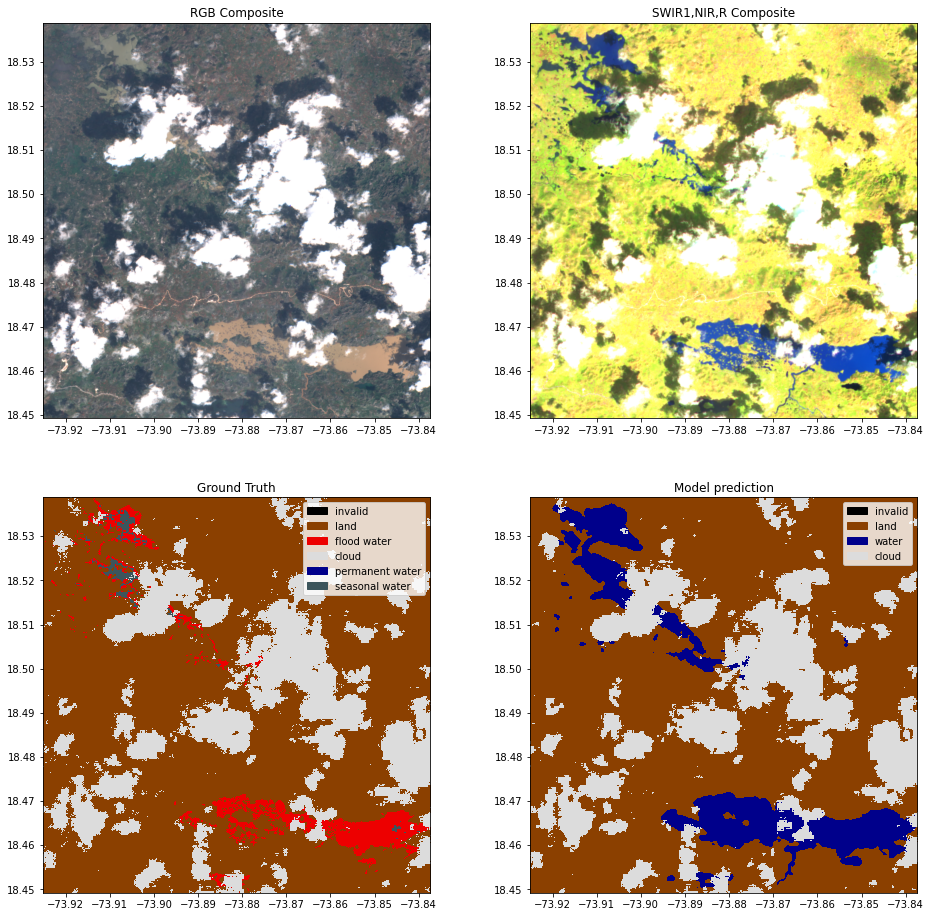

In [12]:
prediction = torch.argmax(outputs, dim=1).long()
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform)

<br>

## <a id='inference_repeat_6f2'></a>5. Repeat the inference process on another Sentinel-2 file

As a last step, you can repeat the inference process on another Sentinel-2 image, which is available as part of the [ml4floods](https://github.com/spaceml-org/ml4floods) project.

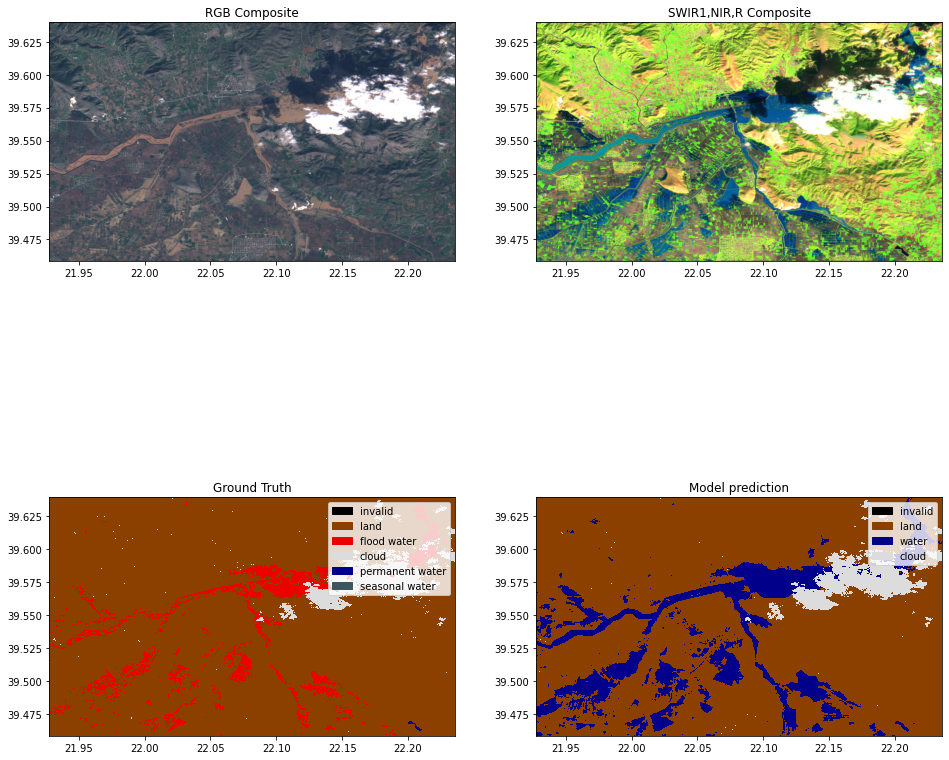

In [14]:
tiff_s2 = "worldfloods_v1_sample/val/S2/EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif"
window = None
channels = get_channel_configuration_bands(config.model_params.hyperparameters.channel_configuration)

torch_inputs, torch_targets, torch_permanent_water, transform = read_inference_pair(tiff_s2, folder_ground_truth="/gt/", 
                                                                                    window=window, 
                                                                                    return_ground_truth=True, 
                                                                                    channels=channels,
                                                                                    folder_permanent_water="/PERMANENTWATERJRC/",
                                                                                    cache_folder=None)

outputs = inference_function(torch_inputs)
prediction = torch.argmax(outputs, dim=1).long()
plot_inference_set(torch_inputs, torch_targets, prediction, torch_permanent_water, transform)

<br>

<br>

<a href="https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring/1/steps/1183058"><< Back to FutureLearn</a><br>

<hr>

<img src='../../img/copernicus_logo.png' alt='Copernicus logo' align='left' width='20%'></img>

Course developed for [EUMETSAT](https://www.eumetsat.int/), [ECMWF](https://www.ecmwf.int/) and [Mercator Ocean International](https://www.mercator-ocean.fr/en/) in support of the [EU’s Copernicus Programme](https://www.copernicus.eu/en) and the [WEkEO platform](https://wekeo.eu/).
